In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import os
import copy

from moviepy.editor import VideoFileClip
from IPython.display import HTML

%matplotlib inline

### Get camera calibration parameters
It gets the information from the camera calibration image set. <br>
At the end, we will have all the information needed to undistort images taken with this camera. 


In [2]:
# prepare object points
nx = 9 # number of inside corners in x
ny = 6 # number of inside corners in y

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

# arrays to store object points and image points from all the image
objpoints = []
imgpoints = []

# prepare object points
objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

img_counter=0
for fname in images:
    img = mpimg.imread(fname)
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)
    # If found, draw corners
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)
    img_counter += 1
    
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)


### Define mask function to isolate region of interest
This function takes as input parameters, a binary image and the polygon defining the region of interest.<br>
It will return the same image with the unwanted information removed.

In [3]:
def region_of_interest(img, vertices):
    
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    
    return masked_image

### Define gradient function
This function takes as input parameter a color image, and optionally treshold limits.<br>
It will get the gradient and use the region of interest -function to get rid of the unwanted information.<br>
At the end, it will return the binary of the lane lines.

In [4]:

def gradient(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    ysize = combined_binary.shape[0]
    xsize = combined_binary.shape[1]
    left_bottom = [0, ysize]
    right_bottom = [xsize, ysize]
    left_top = [xsize/2-50, 3*ysize/5]
    right_top = [xsize/2+50, 3*ysize/5]
    polygon = np.array([ left_bottom, right_bottom, right_top, left_top ], np.int32)
    masked_img = region_of_interest(combined_binary, [polygon])
    
    return masked_img #color_binary

### Define warp function
This function takes as input parameter a binary image of the lane lines.<br>
Inside it, scaling information is defined.<br>
At the end, it will return a transformed image that can be used as an adapted bird view.

In [5]:
def warp(img):
    img_l = img.shape[0]
    img_c = img.shape[1]
    img_size_lc = (img_l, img_c)
    img_size_cl = (img_c, img_l)
    
    # four source coordinates
    src = np.float32(
        [[585, 451],
         [685, 451],
         [267, 673],
         [1030, 673]])
    
    # four desired coordinates
    dst = np.float32(
        [[0+200, 0],
         [img_c-300, 0],
         [0+200, img_l],
         [img_c-300, img_l]])
    
    # compute the perspective transform
    M = cv2.getPerspectiveTransform(src,dst)
    
    # Could compute the inverse also by swapping the input parameters
    Minv = cv2.getPerspectiveTransform(dst,src)
    
    # create the warped image - uses linear interpolation
    warped = cv2.warpPerspective(img, M, img_size_cl, flags=cv2.INTER_LINEAR)
    unwarped = cv2.warpPerspective(img, Minv, img_size_cl, flags=cv2.INTER_LINEAR)
    
    return warped, unwarped


### Define functions for lane lines detection
Detect_lane function will input a binary bird view image and using peaks_detect will identify the lane lines.<br>
At the end it will output detection image, and information about the identified polynomial lines.

In [6]:

def peaks_detect(image):
    histogram = np.sum(image[image.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]/2)
    left_peak = np.argmax(histogram[:midpoint])
    right_peak = np.argmax(histogram[midpoint:]) + midpoint
    
    return (left_peak, right_peak)

def detect_lanes(img):
    
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    binary_warped = img
    
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    
    peaks = peaks_detect(binary_warped)
    leftx_base = peaks[0]
    rightx_base = peaks[1]

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):

        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin

        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)

        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 
    
    # overlay them to the output image
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    y_eval = np.max(ploty)

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 45/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/880 # meters per pixel in x dimension
    
    # Fit new polynomials to x,y in world space
    left_fitx_wld = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fitx_wld = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    # Calculate the new radii of curvature
    left_curverad_wld = ((1 + (2*left_fitx_wld[0]*y_eval*ym_per_pix + left_fitx_wld[1])**2)**1.5) / np.absolute(2*left_fitx_wld[0])
    right_curverad_wld = ((1 + (2*right_fitx_wld[0]*y_eval*ym_per_pix + right_fitx_wld[1])**2)**1.5) / np.absolute(2*right_fitx_wld[0])
    # Now our radius of curvature is in meters and here is the average side values
    avg_curve = (left_curverad_wld+right_curverad_wld)/2
    
    # Identify car offset to lane center
    position_to_center = ((leftx_current + rightx_current)/2 - binary_warped.shape[1]/2) * xm_per_pix
        
    return out_img, ploty, left_fitx, right_fitx, avg_curve, position_to_center 



### Define function to information image to the undistorted original image
This function takes as input an bird view image.<br>
Using the detect_lanes function, it will get the needed information to prepare the information image that at the end will be merged over the undistorted original image.

In [7]:
def merger(org_img, warp_img):
    lanes, ploty, left_fitx, right_fitx, avg_curve, position_to_center = detect_lanes(warp_img)

    plotsL = (left_fitx,ploty)
    plotsL = np.transpose(np.asarray(plotsL))
    plotsR = (right_fitx,ploty)
    plotsR = np.transpose(np.asarray(plotsR))

    img_tst = np.zeros((org_img.shape[0], org_img.shape[1], 3), np.uint8)

    ptsL = plotsL.astype(int)
    ptsR = plotsR.astype(int)
    pts = np.concatenate((ptsL,np.flip(ptsR, axis=0)), axis=0)

    cv2.polylines(img_tst, [pts], False, (255,0,0), thickness=10, lineType=cv2.LINE_AA)
    
    info_img = img_tst.copy()
    cv2.fillPoly(info_img, [pts], color=[0,255,0])

    lixo, expanded_info_img = warp(info_img)
    cv2.rectangle(expanded_info_img, (0, 0), (expanded_info_img.shape[1], 100), (255, 255, 255), -1)

    final_img = cv2.addWeighted(org_img, 0.6, expanded_info_img, 0.4, 0)    
    
    curve_txt = 'Curvature -> %.0f m' % avg_curve
    cv2.putText(final_img, curve_txt, (30,40), 2, 1, (0,0,0), 2, cv2.LINE_AA)
    
    position_txt = 'Offset -> %.2f m' % position_to_center
    cv2.putText(final_img, position_txt, (30,80), 2, 1, (0,0,0), 2, cv2.LINE_AA)
    
    return lanes, final_img


### Open test Images and apply:
* camera correction
* warping for bird eye view
* gradient over bird eye view

In [8]:
# Open a file
path = "test_images"
dirs = os.listdir( path )

orig_img = []
undst_img = []
bird_eye_img = []
binary_img = []
lanes_img = []
output_img = []

img_counter = 0
for fname in dirs:
    img1 = mpimg.imread(path+"/"+fname)
    orig_img.append(img1)
    
    img2 = cv2.undistort(img1, mtx, dist, None, mtx)
    undst_img.append(img2)
    
    img3 = gradient(img2)
    binary_img.append(img3)
    
    warped_img, unwarped_img = warp(img3)
    bird_eye_img.append(warped_img)
    
    img4, img5 = merger(img2, warped_img)
    lanes_img.append(img4)
    output_img.append(img5)
    
    img_counter += 1
    

### Displays test images in different processing phases

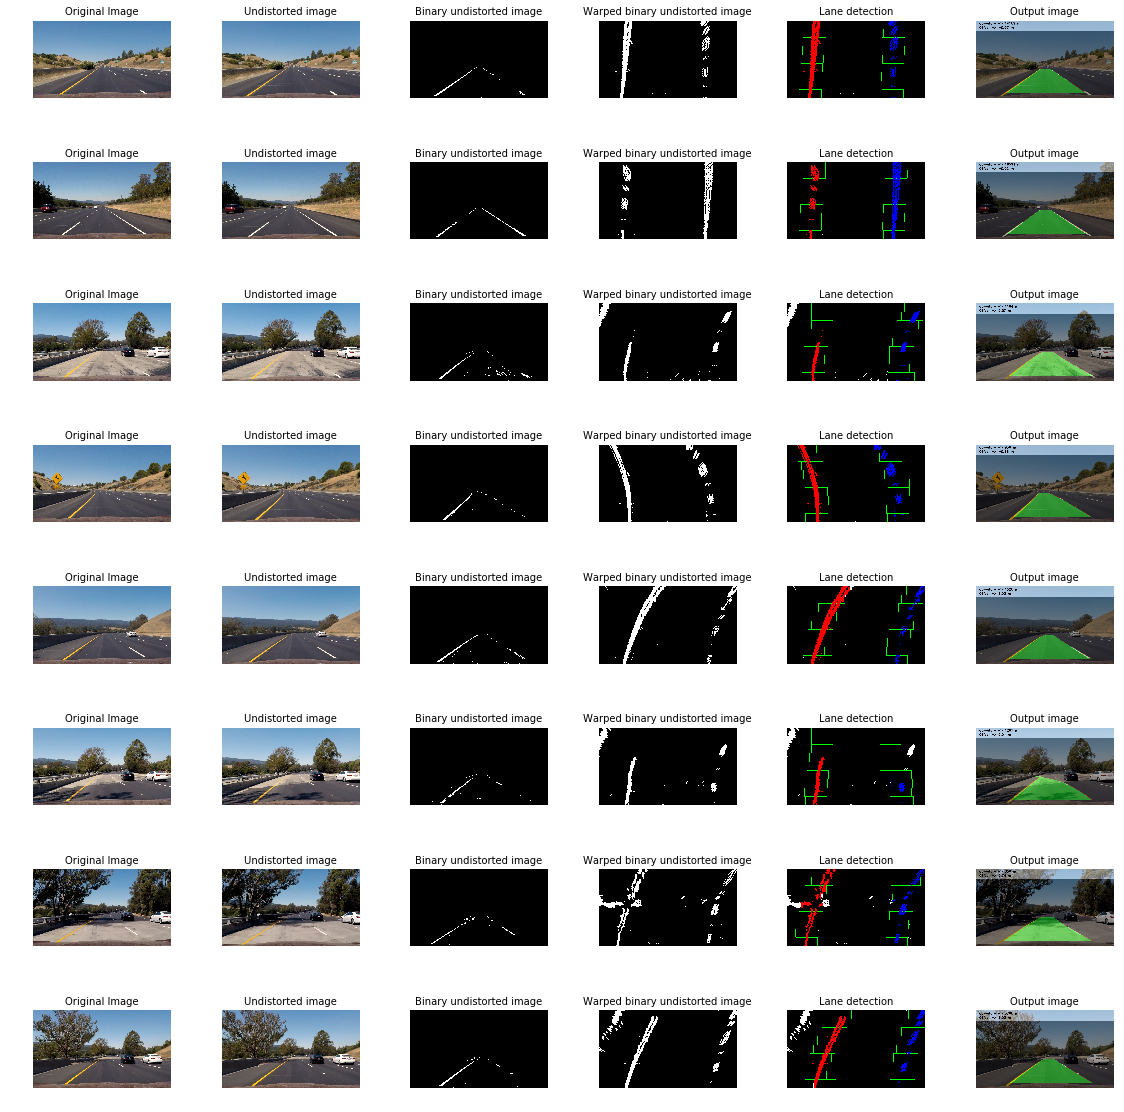

In [9]:
fig, ax = plt.subplots(len(orig_img), 6, figsize=(15, 17))
fig.tight_layout()

for i in range(0,len(orig_img)):
    
    ax[i,0].imshow(orig_img[i])
    ax[i,0].set_title('Original Image', fontsize=10)
    ax[i,0].axis('off')
    
    ax[i,1].imshow(undst_img[i])
    ax[i,1].set_title('Undistorted image', fontsize=10)
    ax[i,1].axis('off')
    
    ax[i,2].imshow(binary_img[i], cmap='gray')
    ax[i,2].set_title('Binary undistorted image', fontsize=10)
    ax[i,2].axis('off')
    
    ax[i,3].imshow(bird_eye_img[i], cmap='gray')
    ax[i,3].set_title('Warped binary undistorted image', fontsize=10)
    ax[i,3].axis('off')
    
    ax[i,4].imshow(lanes_img[i])
    ax[i,4].set_title('Lane detection', fontsize=10)
    ax[i,4].axis('off')
    
    ax[i,5].imshow(output_img[i])
    ax[i,5].set_title('Output image', fontsize=10)
    ax[i,5].axis('off')
    
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    

### Define function that groups all the processing steps
Takes as input parameter an image directly from the camera and outputs the undistorted image merged the detected lane and other information.

In [15]:
def pipeline(input_img):

    # undistort
    undistorted_img = cv2.undistort(input_img, mtx, dist, None, mtx)
    
    # gradient detection
    binary_img = gradient(undistorted_img)
    
    # bird view transformation
    warped_img, lixo = warp(binary_img)
    
    # merge info over undistorted image
    lanes, output_img = merger(undistorted_img, warped_img)
    
    return output_img


### Uses the pipeline with the project video input

In [16]:
output_file1 = './output_images/output_project_video.mp4' 
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("project_video.mp4")
#ADDED updated function name to process the images
output_clip1 = clip1.fl_image(pipeline) #NOTE: this function expects color images!!

%time output_clip1.write_videofile(output_file1, audio=False)

[MoviePy] >>>> Building video ./output_images/output_project_video.mp4
[MoviePy] Writing video ./output_images/output_project_video.mp4


100%|█████████▉| 1260/1261 [03:10<00:00,  6.55it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/output_project_video.mp4 

CPU times: user 4min 51s, sys: 14.5 s, total: 5min 6s
Wall time: 3min 10s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file1))

### Uses the pipeline with the challenge video input

In [20]:
output_file2 = './output_images/output_challenge_video.mp4' 
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip2 = VideoFileClip("challenge_video.mp4")
#ADDED updated function name to process the images
output_clip2 = clip2.fl_image(pipeline) #NOTE: this function expects color images!!

%time output_clip2.write_videofile(output_file2, audio=False)

[MoviePy] >>>> Building video ./output_images/output_challenge_video.mp4
[MoviePy] Writing video ./output_images/output_challenge_video.mp4


100%|██████████| 485/485 [01:07<00:00,  7.10it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/output_challenge_video.mp4 

CPU times: user 1min 44s, sys: 8.83 s, total: 1min 53s
Wall time: 1min 7s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file2))

### Uses the pipeline with the harder challenge video input

In [19]:
output_file3 = './output_images/output_harder_challenge_video.mp4' 
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip3 = VideoFileClip("harder_challenge_video.mp4")
#ADDED updated function name to process the images
output_clip3 = clip3.fl_image(pipeline) #NOTE: this function expects color images!!

%time output_clip3.write_videofile(output_file3, audio=False)

[MoviePy] >>>> Building video ./output_images/output_harder_challenge_video.mp4
[MoviePy] Writing video ./output_images/output_harder_challenge_video.mp4


100%|█████████▉| 1199/1200 [03:24<00:00,  6.09it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/output_harder_challenge_video.mp4 

CPU times: user 4min 54s, sys: 19.1 s, total: 5min 13s
Wall time: 3min 24s


In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output_file3))

### Challenge failures analysis

In [ ]:
clip2.save_frame("./challenge_pics/frame0.png") # by default the first frame is extracted
clip2.save_frame("./challenge_pics/frame1.jpeg", t='00:00:02')
clip2.save_frame("./challenge_pics/frame2.jpeg", t='00:00:04')
clip2.save_frame("./challenge_pics/frame3.jpeg", t='00:00:06')
clip2.save_frame("./challenge_pics/frame4.jpeg", t='00:00:08')
clip2.save_frame("./challenge_pics/frame5.jpeg", t='00:00:10')
clip2.save_frame("./challenge_pics/frame6.jpeg", t='00:00:12')
clip2.save_frame("./challenge_pics/frame7.jpeg", t='00:00:14')
clip2.save_frame("./challenge_pics/frame8.jpeg", t='00:00:16')


In [ ]:
# Open a file
path = "challenge_pics"
dirs = os.listdir( path )

orig_imgV = []
undst_imgV = []
bird_eye_imgV = []
binary_imgV = []
output_imgV = []

img_counter = 0
for fname in dirs:
    img1 = mpimg.imread(path+"/"+fname)
    orig_imgV.append(img1)
    
    img2 = cv2.undistort(img1, mtx, dist, None, mtx)
    undst_imgV.append(img2)
    
    img3 = gradient(img2)
    binary_imgV.append(img3)
    
    warped_img, unwarped_img = warp(img3)
    bird_eye_imgV.append(warped_img)
    
    #img4 = merger(warped_img, img2)
    #output_imgV.append(img4)
    
    img_counter += 1

In [ ]:
fig, ax = plt.subplots(len(orig_imgV), 6, figsize=(15, 17))
fig.tight_layout()

for i in range(0,len(orig_imgV)):
    
    ax[i,0].imshow(orig_imgV[i])
    ax[i,0].set_title('Original Image', fontsize=10)
    ax[i,0].axis('off')
    
    ax[i,1].imshow(undst_imgV[i])
    ax[i,1].set_title('Undistorted image', fontsize=10)
    ax[i,1].axis('off')
    
    ax[i,2].imshow(binary_imgV[i], cmap='gray')
    ax[i,2].set_title('Binary undistorted image', fontsize=10)
    ax[i,2].axis('off')
    
    ax[i,3].imshow(bird_eye_imgV[i], cmap='gray')
    ax[i,3].set_title('Warped binary undistorted image', fontsize=10)
    ax[i,3].axis('off')
    
    lanes, ploty, left_fitx, right_fitx, left_curverad, right_curverad, left_curverad1, right_curverad1 = detect_lanes(bird_eye_imgV[i])
    ax[i,4].imshow(lanes)
    ax[i,4].plot(left_fitx, ploty, color='yellow')
    ax[i,4].plot(right_fitx, ploty, color='yellow')
    ax[i,4].set_title('Lane detection', fontsize=10)
    ax[i,4].axis('off')
    #left_poly.append((left_fitx, ploty))
    #right_poly.append((right_fitx, ploty))
    
    #ax[i,5].imshow(output_imgV[i], cmap='gray')
    #ax[i,5].set_title('Output image', fontsize=10)
    #ax[i,5].axis('off')
    
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

In [ ]:
#plt.imshow(output_img[3])
#plt.title('Output image', fontsize=10)
#plt.axis('off')

for i in range(len(orig_img)):
    testImage = orig_img[i][:]
    lanes, output = pipeline(testImage)

    print(center)

    #plt.imshow(testImage)
    #plt.title('Test image', fontsize=10)
    #plt.axis('off')
    #plt.show()

    #plt.imshow(lanes)
    #plt.title('Test image', fontsize=10)
    #plt.axis('off')
    #plt.show()

    plt.imshow(output)
    plt.title('Test image', fontsize=10)
    plt.axis('off')
    plt.show()


## Writeup 
---

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

[//]: # (Image References)

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video.mp4 "Video"

## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---

### Writeup / README

#### 1. Provide a Writeup / README that includes all the rubric points and how you addressed each one.  You can submit your writeup as markdown or pdf.  [Here](https://github.com/udacity/CarND-Advanced-Lane-Lines/blob/master/writeup_template.md) is a template writeup for this project you can use as a guide and a starting point.  

You're reading it!
Also, I have two different notebook:
- one called training, where different solutions have been tested in order to understand which approach would suit this project best.
- The other one, advancedLaneLines, is focused on getting the project completed, with less disturbing images.

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained in the second code cell of the IPython notebook located in `./training.ipynb` under this title:
**Camera calibration and distortion correction on the calibration images**

This step relies mainly on an available feature from openCV. This feature analyses a chess board like picture in order to detect the existing corners. 
I started by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image, using `cv2.findChessboardCorners`. ` `imgpoints` will be appe`nded with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained an undistorted image.

In order to get a more reliable transformation matrix, it is recommended to run this code over multiple chessboard images. Using all the available images I got this result: 

![calibration][./writeup_images/cam_calibration.png]

### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.

Here we just need to re-use the same code as used on the calibration step.
The code can be found in `./training.ipynb` under this title:
**Distortion correction on the test images**
Here you can see the difference on the test set between the provided images and their undistorted transformation:
![undistorted_images][./writeup_images/undistorted_images.png]

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

Under the training notebook (`./training.ipynb`), several approaches can be found. My final choice, based on the test image set, uses the HLS color spaces and creates a combination of thresholded SobelX to detect vertical lines over the L channel, and  a threshold from the S channel. Then a mask is applied to remove details from outside the road. The code  can be found on the project notebook (`./advancedLaneLines.ipynb`) under this title:
**Define gradient function**
Bellow are several images with labels to provide an overview of what each binary processing code can achieve:

![gradient images][./writeup_images/gradient_images1.png]
![gradient images][./writeup_images/gradient_images2.png]
![gradient images][./writeup_images/gradient_images3.png]
![gradient images][./writeup_images/gradient_images4.png]
![gradient images][./writeup_images/gradient_images5.png]
![gradient images][./writeup_images/gradient_images6.png]

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform includes a function called `warp()`, can be found in `./training.ipynb` under this title:
**Distortion correction on the test images**

The idea is quite simple, we just define the area around the lane, and tranform it to fill the full image area. The practical result is that it will look like a bird eye view, but with different scales for x and y.

I verified that my perspective transform was working as expected by drawing the `src` and `dst` points onto a test image and its warped counterpart to verify that the lines appear parallel in the warped image.

![warped_images][./writeup_images/warped_images.png]

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

This part relies a lot on the quality of the gradient, to get rid of fakes. The code for this step can be found on notebook `./advancedLaneLines.ipynb` under this title:
**Define functions for lane lines detection**
Using an histogram, and detecting the arguments of their peak values, gives us and idea where the lines are.Then I defining a region around that first point, we just need to select the mean point (using numpy mean function) for each y value. Then using the array with the points coodinates, numpy function polyfit will return the parameters of the polinomial equation. With that equation we are now able to trace the identified line:

![detect lines_images][./writeup_images/detecLines_images.png]

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

This step is done on the same function as the previous step.
First I estimated the scale for my lane, 3,7 meters wide and 45 meters long, in order to provide real world values.
Then using it as a factor, I created a polyfit that would be scaled to the real world. Using the resulting equation, we can calculate the radius of the curvature using the function explained on this tutorial: https://www.intmath.com/applications-differentiation/8-radius-curvature.php

About the position of the car, the idea is knowing that the camera is centered, so we just need to identify the lines on the image and the diference between lines and their closest image edges (more acurately, half of it) will provide the distance to the center.

#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

Bellow is the pictur of the final result. On one of them we can clearly see a bad detection of the right line. I will discuss it after the video, where we can see that the pipeline recovers immediately after that.

![end2end_images][./writeup_images/end2end_images.png]

---

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./output_images/output_project_video.mp4)

---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

I consider that my pipeline only has one minor and a small detection issue. None of them are relevent since they are very short in time, and the minor one, does not provide any valuable change to the center of the lane.
On both situations, it happens when there is a road surface change or when the car crosses shadows areas.
That same issue is visible on the challenge video with the sames trigers: surface changes and shadows. Although the detection is not good in this video, I believe that it's lack of accuracy wouldn't cause a crash of the autonomous vehicle.
[link to my challenge video result](./output_images/output_challenge_video.mp4)
With the harder challenge video, the high occurence of shadows creates detections issues that most likely would create some possible crashes (or at least the first one, and then the car would stop :) ).
[link to my harder challenge video result](./output_images/output_harder_challenge_video.mp4)
A valid solution for that issue would be to keep the information of the lines detection from the previous frame and create an area based on that where the probability of having the following lines would be very high.